In [0]:
import os
import time
import datetime

from collections import Counter
import numpy as np
import pandas as pd
from nltk.corpus import stopwords

from nltk.classify import NaiveBayesClassifier
from nltk.corpus import subjectivity
from nltk.sentiment import SentimentAnalyzer
from nltk.sentiment.util import *

from nltk.sentiment.vader import SentimentIntensityAnalyzer
import unicodedata

import matplotlib.pyplot as plt; plt.rcdefaults()
import matplotlib.pyplot as plt

/Users/davidleifer/anaconda/lib/python3.5/site-packages/nltk/twitter/__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "


In [0]:
data = '/Users/davidleifer/Desktop/grant_work/working/twitter-code/user-tweets/TwitterEnergyData/json-data/energy20170801T140040.json'
#data = '/Users/davidleifer/Desktop/grant_work/working/twitter-code/user-tweets/TwitterEnergyData/merged.json'

hashtag_list = ['#Crudeoil', '#crude', '#oil', '#gasoline', 
                '#OOTT', '#OPEC', '#algae', '#biodiesel', 
                '#bioethanol', '#Biogas', 
                '#biofuel', '#biofuels', 
                '#ethanol', '#biomass', 
                '#RFS', '#Fuelcell', '#hydrogen', 
                #'#FossilEnergy', 
                '#GreenEnergy', '#thermal', '#coal', 
                '#coalmine', '#geothermal', '#hydroenergy', 
                '#MethaneHydrates', '#biomethane', '#biopower', '#natgas', 
                #'#AdvancedBiofuels', 
                '#naturalgas', '#SynthesisGas', 
                '#nuclearenergy', '#nuclear', '#OTEC', '#renewable', '#RenewableEnergy', '#TidalEnergy', 
                '#WaveEnergy', '#oceanenergy', '#shalegas', '#solarfarm', '#solar', '#SolarPower', 
                '#SolarEnergy', '#SolarPanels', '#WindEnergy', '#hydropower', '#hydroenergy', '#windfarm', 
                '#WindTurbine', '#RenewableNaturalGas', '#wastetofuel', 
                ##'#envirofuel', 
                '#wastetoenergy'
               ]

Begin processing #wastetoenergy 04:15:29
Clean data #wastetoenergy 04:25:37


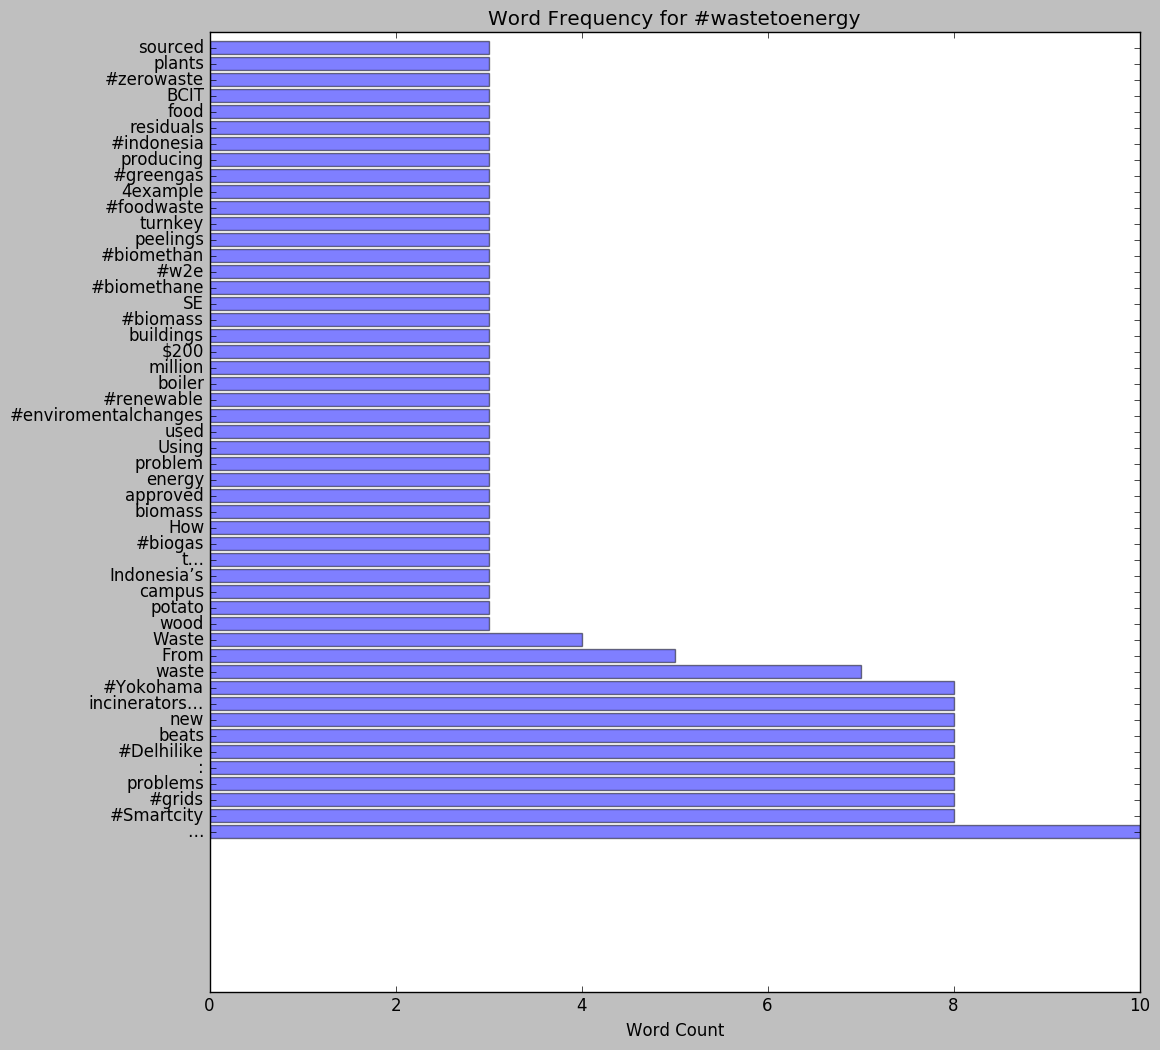

Start sentiment analysis #wastetoenergy 04:25:39


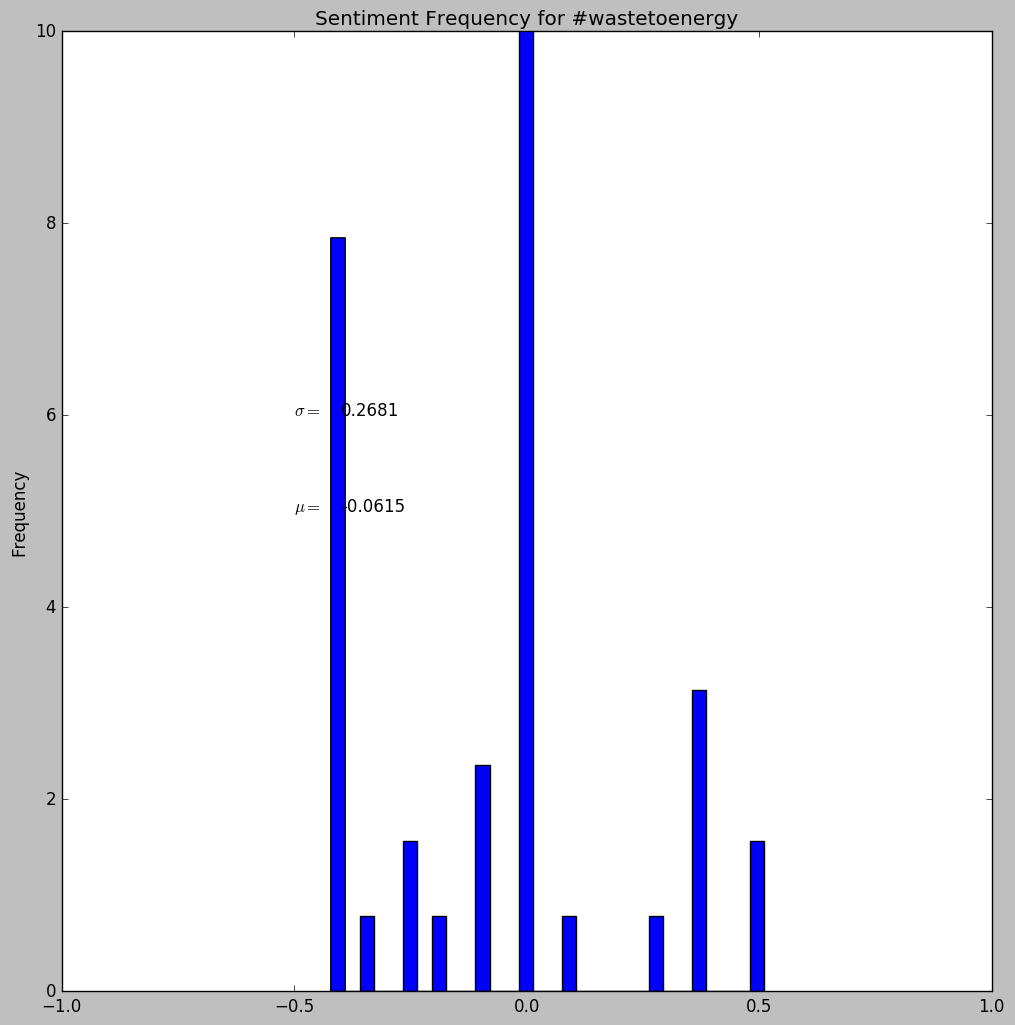

Finished Processing 04:25:40


In [0]:
for i, s in enumerate(hashtag_list):
    hashtag_list[i] = s.strip()
    
    print("Begin processing " + hashtag_list[i] ,datetime.datetime.now().strftime("%H:%M:%S"))
    df = pd.read_json(data, lines=True)
    df = df[df['text'].str.contains(hashtag_list[i], na = False)]
    stop = stopwords.words('english')
    df['tweet_without_stopwords'] = df['text'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))
    stop =  ['The','RT','&amp;', '-', 'A', 'https:', '.', '2']
    df['tweet_without_stopwords'] = df['tweet_without_stopwords'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))
    df['tweet_without_stopwords'] = df['tweet_without_stopwords'].str.replace(r'(?:\@|https?\://)\S+', '')
    
    print("Clean data " + hashtag_list[i] ,datetime.datetime.now().strftime("%H:%M:%S"))
    #remove periods
    df['tweet_without_stopwords'] = df['tweet_without_stopwords'].str.replace('[\.]','')
    #remove commas
    df['tweet_without_stopwords'] = df['tweet_without_stopwords'].str.replace('[\,]','')
    #remove -
    df['tweet_without_stopwords'] = df['tweet_without_stopwords'].str.replace('[-]','')
    #remove @
    df['tweet_without_stopwords'] = df['tweet_without_stopwords'].str.replace('[@]','')
    #remove hashtag_list
    df['tweet_without_stopwords'] = df['tweet_without_stopwords'].str.replace(hashtag_list[i],'')

    #count frequency
    count = Counter(" ".join(df["tweet_without_stopwords"]).split()).most_common(50)
    count = pd.DataFrame(count)
    count.columns = ['Word', 'Count']

    #create bar chart of frequency
    X = count['Word']
    Y = count['Count'] 
    y_pos = np.arange(len(X))
    fig_size = plt.rcParams["figure.figsize"]
    fig_size[0] = 12
    fig_size[1] = 12
    plt.rcParams["figure.figsize"] = fig_size
    plt.barh(y_pos, Y, align='center', alpha=0.5)
    plt.yticks(y_pos, X)
    plt.xlabel('Word Count')
    plt.title('Word Frequency for ' + hashtag_list[i])
    plt.savefig('TwitterEnergyData/hashtag-bar-histo/' + hashtag_list[i] + '-bar.png')
    plt.show()
    
    tweets = df['tweet_without_stopwords']
    df = pd.DataFrame(tweets)
    df["compound"] = ''
    df["neg"] = ''
    df["neu"] = ''
    df["pos"] = ''
    sid = SentimentIntensityAnalyzer()
    
    print("Start sentiment analysis " + hashtag_list[i] ,datetime.datetime.now().strftime("%H:%M:%S"))    
    for user, row in df.T.iteritems():
        try:
            sentence = unicodedata.normalize('NFKD', df.loc[user, 'tweet_without_stopwords'])
            ss = sid.polarity_scores(sentence)
            df.set_value(user, 'compound', ss['compound'])
            df.set_value(user, 'neg', ss['neg'])
            df.set_value(user, 'neu', ss['neu'])
            df.set_value(user, 'pos', ss['pos'])
        except TypeError:
            print(df.loc[user, 'tweet_without_stopwords'])
    
    #save to file
    filename = 'TwitterEnergyData/hashtag-sentiment-analysis/' + hashtag_list[i] + '.csv'
    df.to_csv(filename, index=False, encoding='utf-8')
    
    #fig_size = plt.rcParams["figure.figsize"]
    #plt.rcParams["figure.figsize"] = fig_size
    plt.xlim(xmin=-1, xmax = 1)
    plt.ylim(ymin=0, ymax = 10)
    fig_size[0] = 12
    fig_size[1] = 9
    x = df['compound']
    
    mn = np.mean(df['compound'])
    mn = round(mn, 4)
    std = np.std(df['compound'])
    std = round(std, 4)
    plt.text(-.5, 5, '$\mu=$')
    plt.text(-.5, 6, '$\sigma=$')
    plt.text(-.4, 5, mn)
    plt.text(-.4, 6, std)
    
    plt.hist(x, normed=True, bins=30)
    plt.ylabel('Frequency');
    plt.title('Sentiment Frequency for ' + hashtag_list[i])
    plt.savefig('TwitterEnergyData/hashtag-bar-histo/' + hashtag_list[i] + '-histo.png')
    plt.show()

print("Finished Processing" ,datetime.datetime.now().strftime("%H:%M:%S"))